##### **Blog Content Generation AI Workflow**

In [1]:
# Importing the necessary libraries
from typing import Annotated
from typing_extensions import TypedDict,Literal,List
from langchain_groq import ChatGroq
from langgraph.graph import END, START, MessageGraph
from langgraph.graph.state import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from langchain_core.messages import BaseMessage
from langchain_core.runnables import RunnableConfig
from langchain_core.messages import AnyMessage
from langgraph.types import interrupt,Command
from langgraph.checkpoint.memory import MemorySaver
from langchain.prompts import ChatPromptTemplate
from pydantic import BaseModel
from pydantic.fields import Field
from langchain.tools.tavily_search import TavilySearchResults
from langchain_core.documents import Document
import os
from dotenv import load_dotenv

In [2]:
# Loading the environment variables
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

In [3]:
# Loading the LLM model
# llm = ChatGroq(model="llama-3.2-11b-vision-preview",temperature=0)
llm = ChatGroq(model="qwen-2.5-32b",temperature=0.5)

In [4]:
# defining the state (message state)
class MessageState(TypedDict):
    input_query: str
    query_rewriting:Literal["yes","no"]
    documents: List[str]
    content: str

In [5]:
# define the memory
memory = MemorySaver()

In [6]:
# flow 
# start --> grade query --> query constructor --> web search (5 blog post) --> grade documents --> rewrite query (if grade documents is false) --> generate the blog --> human feedback --> end

##### Query Grader Node

In [7]:
# Query Grader Model

class QueryGraderModel(BaseModel):
    """Evaluates whether a given input is well-structured and specific for searching blog content on the web."""
    binary_score: Literal["yes","no"] = Field("Indicates whether the input is well-structured and specific for searching blog content on the web. Accepts 'yes' or 'no'.")
    
system = """
You are an AI-powered query evaluator. Your task is to assess whether a given input query is well-structured, 
specific, and suitable for searching blog content on the web.

Clarity = The query should be understandable and unambiguous.
Specificity = It should be detailed enough to generate relevant blog search results.
Search Intent = The query should be framed to retrieve blog-style content rather than unrelated results.
Completeness = The query should provide enough context to guide a search effectively.

You must return a binary score:
"yes" → If the query is well-structured and specific for searching blog content.
"no" → If the query is too vague, unclear, or unsuitable for blog searches.

Examples:
Valid Queries (yes)

"Best AI tools for content writers in 2024"
"How to optimize a WordPress blog for SEO?"
"Top Python frameworks for web development in 2024"

Invalid Queries (no)

"AI tools?" (Too vague)
"Fix laptop?" (Not framed for blog search)
"Latest news on Apple" (Better suited for news, not blogs)
"""

QueryGraderPrompt = ChatPromptTemplate.from_messages([
    ("system",system),
    ("human","Grade the input query: {question}")
])

QueryGraderLLM = llm.with_structured_output(QueryGraderModel)
QueryGraderChain = (QueryGraderPrompt | QueryGraderLLM)

QueryGraderChain.invoke({"question":"Data Science"})

QueryGraderModel(binary_score='no')

In [8]:
# grade query node
def grade_query_node(state:MessageState):
    """
    Determines whether a given input is well-structured and specific for searching blog content on the web

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): 
    """
    print("----- CHECKING THE USER INPUT WHETHER WELL-STRUCTURE FOR WEB-SEARCH OR NOT -----")
    input_query = state["input_query"]
    query_grader = QueryGraderChain.invoke({"question":input_query})
    binary_score = query_grader.binary_score
    
    if binary_score == "yes":
        query_rewriting = "no"
    elif binary_score == "no":
        query_rewriting = "yes"
    return {"input_query":input_query,"query_rewriting":query_rewriting}
        

##### Query Rewriter Node

In [9]:
# Query Rewriter Model

class RewriteQueryModel(BaseModel):
    """Rewrite the question in consise and clear format"""
    question:str = Field(description="Rewritten question into web search based format")

# Few shot Prompt / examples
system = """
You are an advanced AI designed to optimize technology-related search input. 
Your goal is to rewrite user-provided search input into more improve, clarical and 
search engine effective format into proper complete sentence while preserving intent. 

1. Enhance Specificity = Add relevant keywords, versions, and use cases for better precision.
2. Remove Ambiguity = Clarify vague terms to match search engine expectations.
3. Use Natural Language = Keep the input readable and structured for efficient searching.
4. Optimize for Blog Content = Transform the input into a structured topic suitable for an in-depth blog post.
5. Improve Searchability = Reframe the input to match how users search for blogs online.

Examples:
question: "AI tools for developers?"
Output: "Top AI-powered coding assistants for developers in 2025: GitHub Copilot, CodeWhisperer, and more"

question: "fastest web hosting?"
Output: "Best high-speed web hosting providers in 2025 for low-latency websites"

question: "ai agents"
Output: "Trending Agentic AI Frameworks in 2025"
"""

QueryRewriterPrompt = ChatPromptTemplate.from_messages([
    ("system",system),
    ("human","Rewrite the following query properly: {question}")
])

QueryRewriterLLM = llm.with_structured_output(RewriteQueryModel)
QueryRewriterChain = (QueryRewriterPrompt | QueryRewriterLLM)

In [10]:
QueryRewriterChain.invoke({"question":"Data science"})

RewriteQueryModel(question='What are the key concepts and tools in data science for 2025?')

In [36]:
def rewrite_query_node(state:MessageState):
    """
    Rewite the user query into more well-structured and search engine effective format

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): 
    """
    print("----- REWRITING THE USER QUERY -----")
    input_query = state["input_query"]
    rewritten_query = QueryRewriterChain.invoke({"question":input_query})
    return {"input_query":rewritten_query.question}

##### Web search Node

In [37]:
def web_search_node(state:MessageState):
    """
    Web search based on the re-written question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): 
    """
    print("----- PERFORMING WEB SEARCH -----")
    input_query = state["input_query"]
    
    print("Input Query : ",input_query)
    tavily_search_tool = TavilySearchResults(description=("A search engine optimized for discovering comprehensive, accurate, and trusted technical blog content."
        "It is designed to help users find high-quality blogs that answer technical questions across various technology domains"
        "Input should be a search query."),k=5
    )
    docs = tavily_search_tool.invoke({"query":input_query})
    documents = [Document(doc["content"]) for doc in docs]
    print(documents)
    return {"documents":documents}

##### Content Generation Node

In [43]:
system = """
"You are an AI-powered technical blog writer. Your task is to generate user-centric, engaging, and well-structured blog content based on web-scraped articles. "
"Create a clear, specific, and complete blog with an attractive title and logical sections for better readability. "
"Use simple Indian English to ensure accessibility."
"""
ContentGeneratorPrompt = ChatPromptTemplate.from_messages([
    ("system",system),
    ("human","Write a well-structured blog based on the given documents: {documents}")
])
ContentGeneratorLLM = ChatGroq(model="qwen-2.5-32b",temperature=0.5)
ContentGeneratorChain = (ContentGeneratorPrompt | ContentGeneratorLLM)

def generate_content_node(state:MessageState):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, output : contains LLM generated output
    """
    print("----- GENERATING THE CONTENT -----")
    documents = state["documents"]
    generated_content = ContentGeneratorChain.invoke({"documents":documents})
    return {"content":generated_content}

##### Should Rewrite Query Conditional Node

In [44]:
def should_rewrite_query(state):
    """
    Determines whether to rewrite the query, or not rewrite the query.

    Args:
        state (dict): The current graph state

    Returns:
        str: 
    """
    shouldwrite = state["query_rewriting"]
    if shouldwrite == "yes":
        return "RewriteQuery"
    else:
        return "WebSearch"

##### Workflow

In [45]:
# Generate the workflow
workflow = StateGraph(MessageState)

workflow.add_node("GradeQuery",grade_query_node)
workflow.add_node("RewriteQuery",rewrite_query_node)
workflow.add_node("WebSearch",web_search_node)
workflow.add_node("GenerateContent",generate_content_node)

workflow.add_edge(START,"GradeQuery")
workflow.add_conditional_edges("GradeQuery",should_rewrite_query,{'RewriteQuery':'RewriteQuery','WebSearch':'WebSearch'})
workflow.add_edge("WebSearch","GenerateContent")
workflow.add_edge("RewriteQuery","WebSearch")
workflow.add_edge("WebSearch","GenerateContent")
workflow.add_edge("GenerateContent",END)

app = workflow.compile()

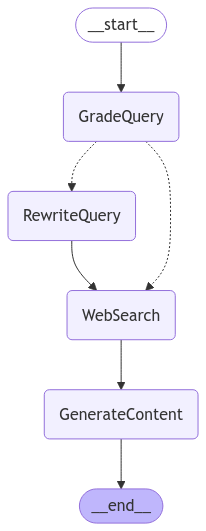

In [46]:
app

In [48]:
from pprint import pprint
inputs = {"input_query":"Agentic Ai frameworks?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
# Final generation
pprint(value["content"].content)

----- CHECKING THE USER INPUT WHETHER WELL-STRUCTURE FOR WEB-SEARCH OR NOT -----
"Node 'GradeQuery':"
----- REWRITING THE USER QUERY -----
"Node 'RewriteQuery':"
----- PERFORMING WEB SEARCH -----
Input Query :  What are the leading agentic AI frameworks in 2025?
[Document(metadata={}, page_content='Top 5 Agentic AI Frameworks to Watch in 2025 | by Lekha Priya | Jan, 2025 | Medium Top 5 Agentic AI Frameworks to Watch in 2025 https://www.analyticsvidhya.com/blog/2024/07/ai-agent-frameworks/ Microsoft AutoGen provides unparalleled support for creating systems that require multi-agent collaboration, making it ideal for use cases like IT infrastructure management and cloud automation. CrewAI’s ability to handle multi-agent collaboration makes it a go-to framework for projects requiring team-based problem-solving, like logistics and resource planning. These frameworks are more than just tools — they’re blueprints for the future of Agentic AI. Agentic AI frameworks like Microsoft AutoGen, Lan

In [50]:
import requests

In [53]:
def fetch_github_code(repo: str, file_path: str):
    url = f"https://raw.githubusercontent.com/{repo}/refs/heads/main/{file_path}"
    response = requests.get(url)
    if response.status_code == 200:
        return response.text
    return "Error fetching code."

In [58]:
response = fetch_github_code(repo="45-Hrishi/MCQ-Generator-LLM-Application",file_path="src/mcq_generator/mcq_generator.py")

In [17]:
def clean_script(script):
    lines = script.split("\n")
    cleaned_lines = []
    
    for line in lines:
        # Remove Jupyter magic commands (like %matplotlib inline, %timeit, etc.)
        if line.strip().startswith("%") or line.strip().startswith("!") or line.startswith('# In['):
            continue
        
        cleaned_lines.append(line)

    return "\n".join(cleaned_lines)

In [18]:
import nbformat
from nbconvert import PythonExporter

def convert_notebook_to_script(notebook_path, script_path):
    with open(notebook_path, "r", encoding="utf-8") as f:
        notebook_content = nbformat.read(f, as_version=4)
    
    python_exporter = PythonExporter()
    script, _ = python_exporter.from_notebook_node(notebook_content)

    
    # Clean the script
    cleaned_script = clean_script(script)

    with open(script_path, "w", encoding="utf-8") as f:
        f.write(cleaned_script)

# Example usage
convert_notebook_to_script("research.ipynb", "output_script.py")